In [1]:
import pandas as pd

true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')
true_df['label'] = 1
fake_df['label'] = 0
df = pd.concat([true_df, fake_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


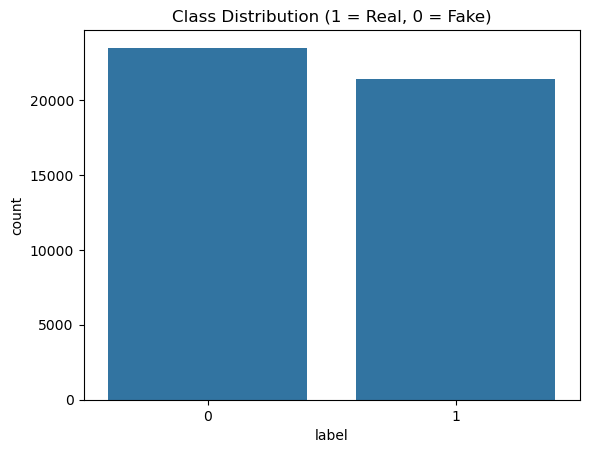

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title('Class Distribution (1 = Real, 0 = Fake)')
plt.show()


In [5]:
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


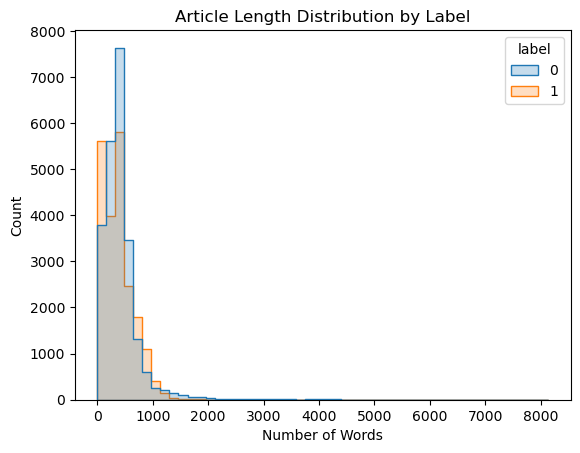

In [7]:
# Compute word counts
df['text_length'] = df['text'].str.split().apply(len)

# Plot distribution
sns.histplot(data=df, x='text_length', hue='label', bins=50, element='step')
plt.title('Article Length Distribution by Label')
plt.xlabel('Number of Words')
plt.show()


In [9]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply to the text column
df['clean_text'] = df['text'].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91702\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91702\AppData\Roaming\nltk_data...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label']


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9880846325167038

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.98      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



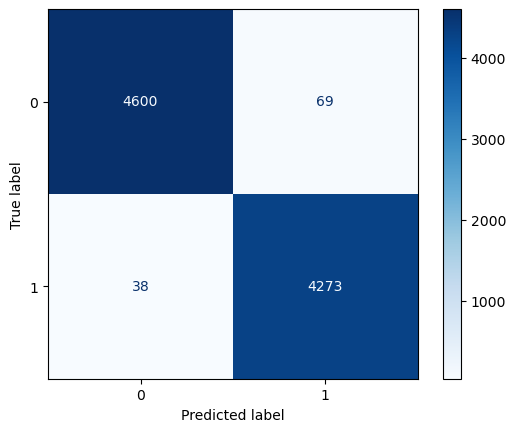

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')


Training: Logistic Regression
Training: Multinomial NB
Training: Random Forest


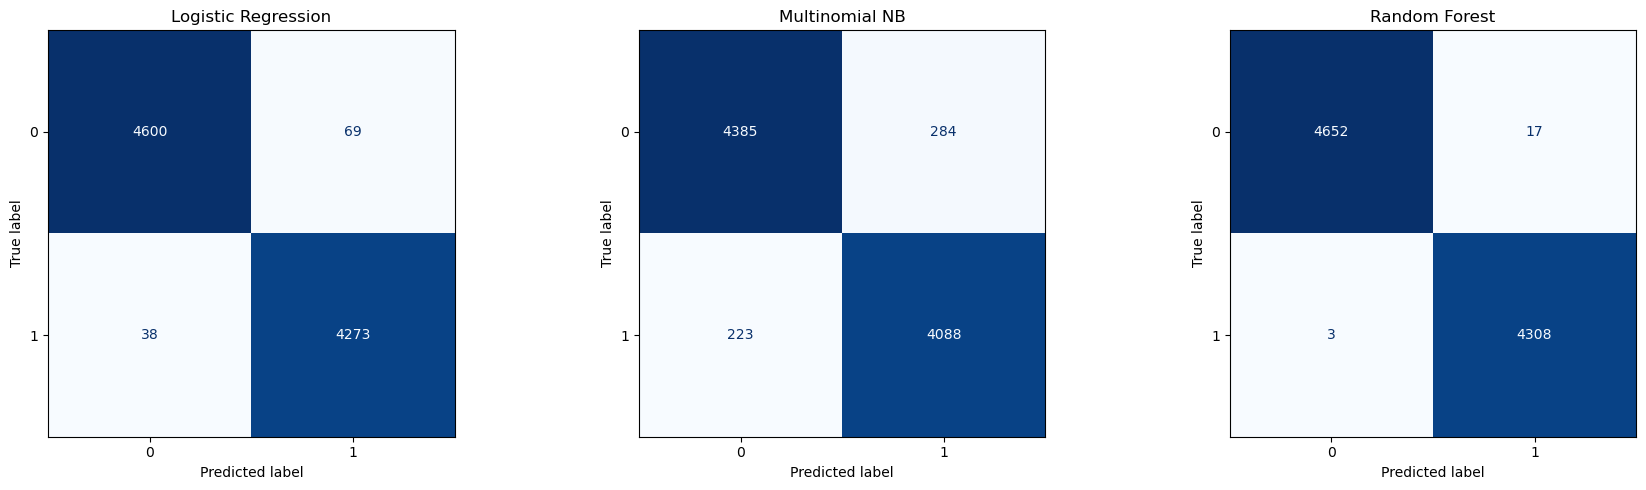

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)  # Fewer trees = faster
}

# Set up the subplots
fig, axes = plt.subplots(1, len(models), figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    print(f"Training: {name}")  # Log progress
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, ax=ax, cmap='Blues', colorbar=False
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import classification_report

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['macro avg']['f1-score']
    print(f"{name} — Macro F1: {f1:.4f}")


Logistic Regression — Macro F1: 0.9881
Multinomial NB — Macro F1: 0.9435
Random Forest — Macro F1: 0.9978


In [28]:
from sklearn.model_selection import cross_val_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
rf = RandomForestClassifier(n_estimators=50, random_state=42)

print("Random Forest CV results:")
for metric in scoring:
    scores = cross_val_score(rf, X, y, cv=5, scoring=metric)
    print(f"{metric:16s}: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest CV results:
accuracy        : 0.9980 ± 0.0008
precision_macro : 0.9979 ± 0.0009
recall_macro    : 0.9980 ± 0.0008
f1_macro        : 0.9980 ± 0.0009


In [32]:
import joblib

# Train RF on full dataset
rf_final = RandomForestClassifier(n_estimators=50, random_state=42)
rf_final.fit(X, y)

# Save model and vectorizer
joblib.dump(rf_final, 'random_forest_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("✅ Model and vectorizer saved!")


✅ Model and vectorizer saved!


In [44]:
def predict_news(text, model, vectorizer):
    clean = preprocess(text)
    vect = vectorizer.transform([clean])
    pred = model.predict(vect)[0]
    return "REAL" if pred == 1 else "FAKE"

# Load saved model (if needed)
model = joblib.load('random_forest_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Try a sample
print(predict_news("India's GDP grows by 6.1% in the first quarter of 2023, says Finance Ministry.", model, vectorizer))


FAKE


In [46]:
print(df['label'].value_counts())


label
0    23481
1    21417
Name: count, dtype: int64


In [48]:
# Grab a real article from your actual dataset
sample_real = df[df['label'] == 1].iloc[0]['text']
print("Sample real news:\n", sample_real[:500])  # preview first 500 characters

# Predict
print("Prediction:", predict_news(sample_real, model, vectorizer))


Sample real news:
 SAN FRANCISCO (Reuters) - California Attorney General Xavier Becerra said on Friday he was “prepared to take whatever action it takes” to defend the Obamacare mandate that health insurers provide birth control, now that the Trump administration has moved to circumvent it. The administration’s new contraception exemptions “are another example of the Trump administration trampling on people’s rights, but in this case only women,” Becerra told Reuters.  Becerra and other Democratic attorneys genera
Prediction: REAL
